 <h1>Assignments</h1>

In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
# Import Keras
from keras import backend as K
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
# import library
import talos as ta
from keras import optimizers
from keras.activations import relu
from talos.utils import live # Live Monitoring # enable live training plot

Using TensorFlow backend.


In [2]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [9]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [10]:
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [11]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [12]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [13]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [14]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))
print(n_classes)
X_train.shape

128
9
7352
6


(7352, 128, 9)

- Defining the Architecture of LSTM

In [17]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [29]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/29
7352/7352 [==============================] - 47s 6ms/step - loss: 0.1773 - acc: 0.9486 - val_loss: 0.4807 - val_acc: 0.9060
Epoch 2/29
7352/7352 [==============================] - 44s 6ms/step - loss: 0.1390 - acc: 0.9524 - val_loss: 0.4571 - val_acc: 0.8931
Epoch 3/29
7352/7352 [==============================] - 44s 6ms/step - loss: 0.1423 - acc: 0.9508 - val_loss: 0.4182 - val_acc: 0.9128
Epoch 4/29
7352/7352 [==============================] - 44s 6ms/step - loss: 0.1478 - acc: 0.9476 - val_loss: 0.5644 - val_acc: 0.8989
Epoch 5/29
7352/7352 [==============================] - 47s 6ms/step - loss: 0.1472 - acc: 0.9504 - val_loss: 0.4882 - val_acc: 0.9023
Epoch 6/29
7352/7352 [==============================] - 47s 6ms/step - loss: 0.1357 - acc: 0.9505 - val_loss: 0.4380 - val_acc: 0.9033
Epoch 7/29
7352/7352 [==============================] - 50s 7ms/step - loss: 0.1310 - acc: 0.9531 - val_loss: 0.4990 - val_acc: 0.9067
Epoch 8

In [30]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 525       12         0        0                   0   
SITTING                  0      378       108        0                   4   
STANDING                 0       93       439        0                   0   
WALKING                  0        1         2      439                  22   
WALKING_DOWNSTAIRS       0        0         0        2                 410   
WALKING_UPSTAIRS         0        1         0       14                   9   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING                           32  
WALKING_DOWNSTAIRS                 8  
WALKING_UPSTAIRS                 447  


In [31]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 2s 561us/step


In [32]:
score

[0.5767476545911808, 0.8951476077366813]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

<h1><center> Hyper Parameter Tuning with Talos </center></h1>
![title](logo.png)

In [17]:
# https://autonomio.github.io/docs_talos/#introduction
# https://github.com/autonomio/talos

from talos.model.early_stopper import early_stopper
def lstm_model(x_train, y_train, x_val, y_val, params):

    model = Sequential()
    
    model.add(LSTM(units=params['first_neuron'],input_shape=(timesteps, input_dim)))
    model.add(Dropout(rate=params['dropout']))
    model.add(Dense(n_classes, activation='softmax')) 
    model.compile(optimizer=params['optimizer'],loss=params['losses'],metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, validation_data=[x_val, y_val], batch_size=params['batch_size'],
                        callbacks=[live(),early_stopper(params['epochs'])],epochs=params['epochs'],verbose=2)

    return history, model

In [16]:
params = {
    'optimizer': ['Adam','Nadam'],
    'losses': ['binary_crossentropy'],
    'first_neuron': [16, 32, 64],
    'batch_size': [16,32],
    'epochs': [30],
    'dropout': [0.3,0.4,0.5,0.6,0.7]
}

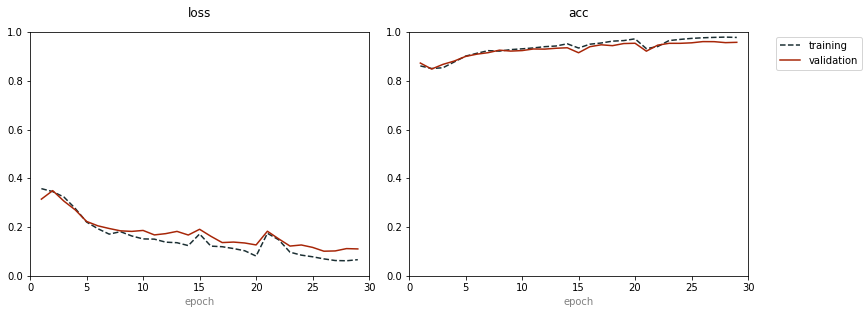

100%|███████████████████████████████████████████████████████████████████████████████| 60/60 [7:39:13<00:00, 558.84s/it]


In [18]:
h = ta.Scan(x=X_train, y=Y_train,x_val=X_test, y_val=Y_test,
          model=lstm_model,
          params=params, search_method='random',
          shuffle=True, dataset_name='UCI_HAR_Dataset',
          experiment_no='1', seed=42)

In [19]:
h.details

experiment_name        UCI_HAR_Dataset_1
random_method           uniform_mersenne
reduction_method                    None
reduction_interval                    50
reduction_window                      20
grid_downsample                        1
reduction_threshold                  0.2
reduction_metric                 val_acc
reduce_loss                        False
complete_time             08/18/19/04:44
x_shape                   (7352, 128, 9)
y_shape                        (7352, 6)
dtype: object

In [51]:
h.data.head(5)

,round_epochs,val_loss,val_acc,loss,acc,optimizer,losses,first_neuron,batch_size,epochs,dropout,None
0,19,0.135219,0.956736,0.129088,0.952439,Nadam,binary_crossentropy,16,16,30,0.6,0
1,9,0.094286,0.965954,0.074021,0.973930,Nadam,binary_crossentropy,64,16,30,0.6,1
2,25,0.131649,0.950967,0.120538,0.955137,Adam,binary_crossentropy,16,32,30,0.6,2
3,8,0.183931,0.920032,0.149868,0.932785,Nadam,binary_crossentropy,16,16,30,0.3,3
4,11,0.096246,0.966633,0.064050,0.975812,Adam,binary_crossentropy,64,16,30,0.5,4


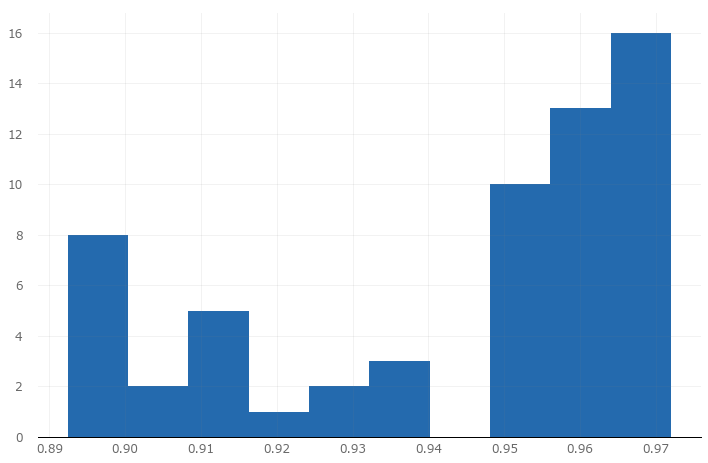

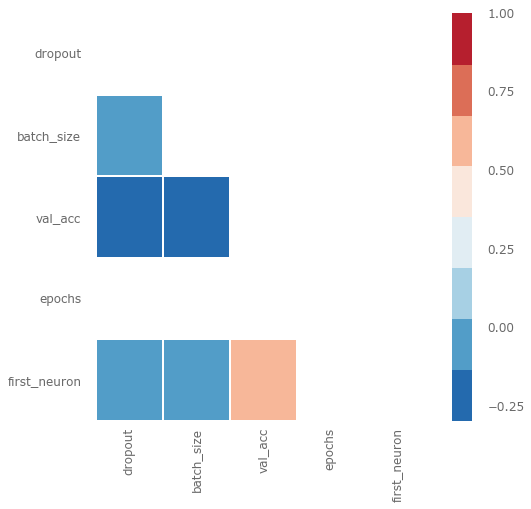

In [35]:
%matplotlib inline
r = ta.Reporting(h)
# a simple histogram 
r.plot_hist(bins=10)
# heatmap correlation
r.plot_corr()

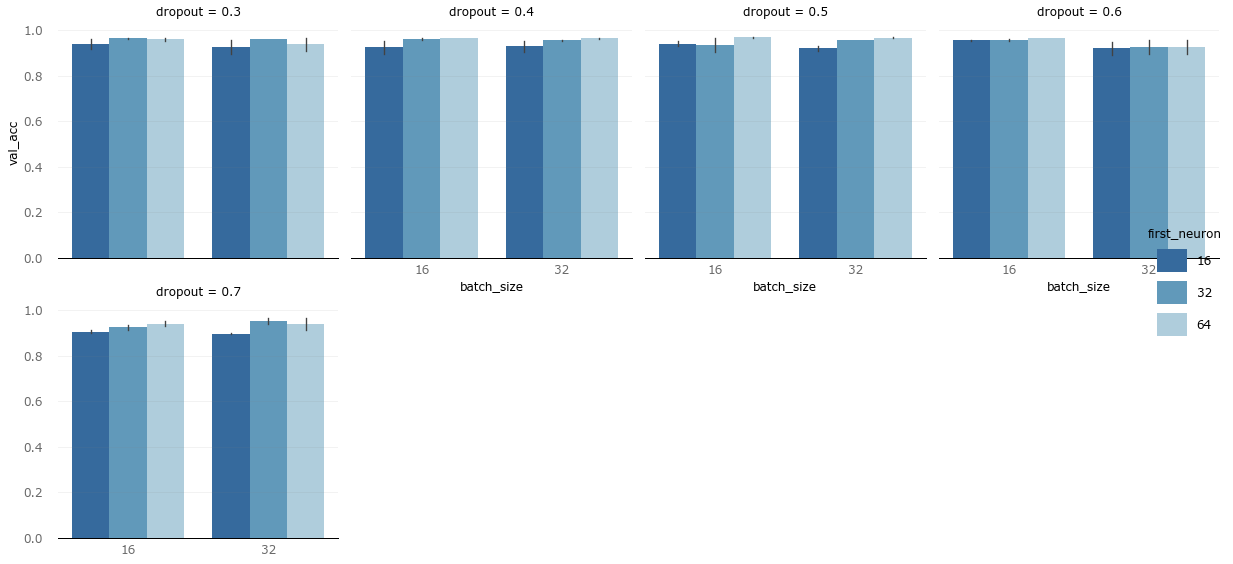

In [38]:
r.plot_bars('batch_size', 'val_acc', 'first_neuron', 'dropout')

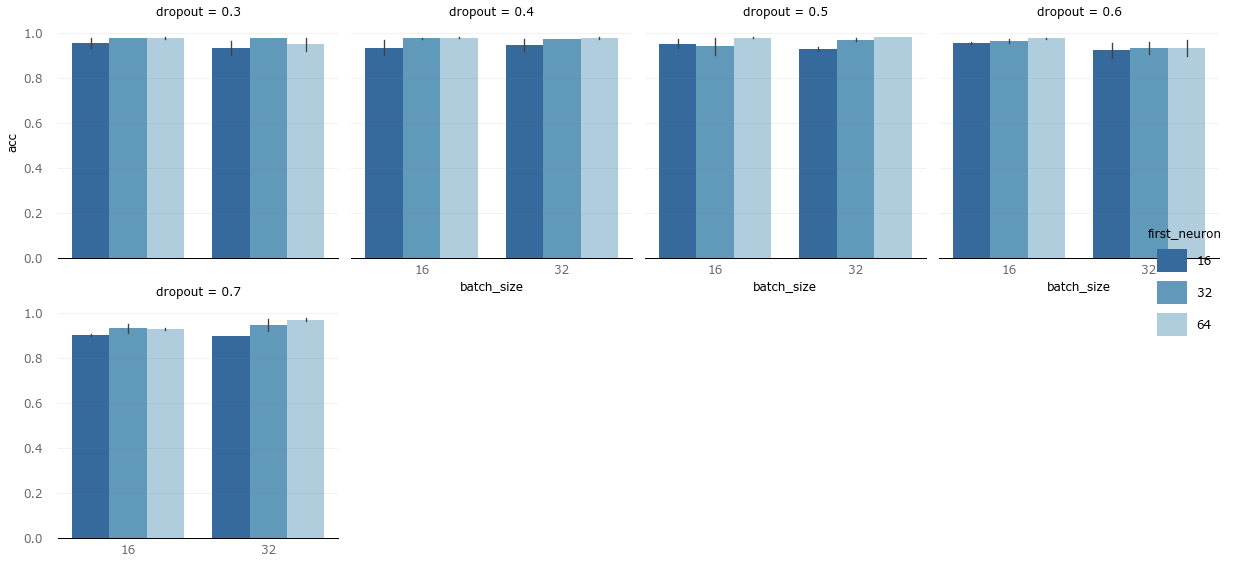

In [39]:
r.plot_bars('batch_size', 'acc', 'first_neuron', 'dropout')

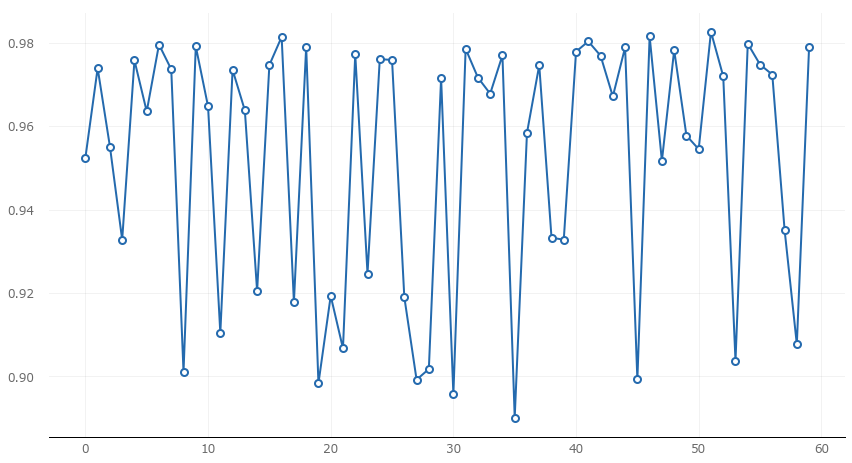

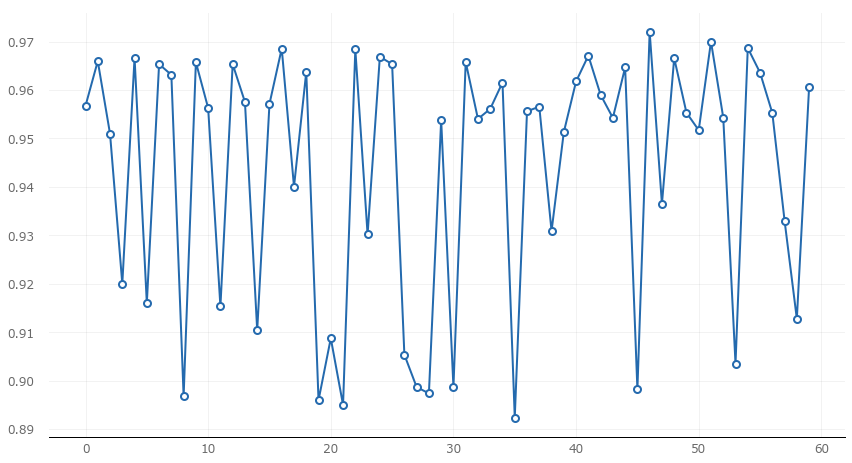

In [41]:
# line plot
r.plot_line(metric='acc')
r.plot_line(metric='val_acc')

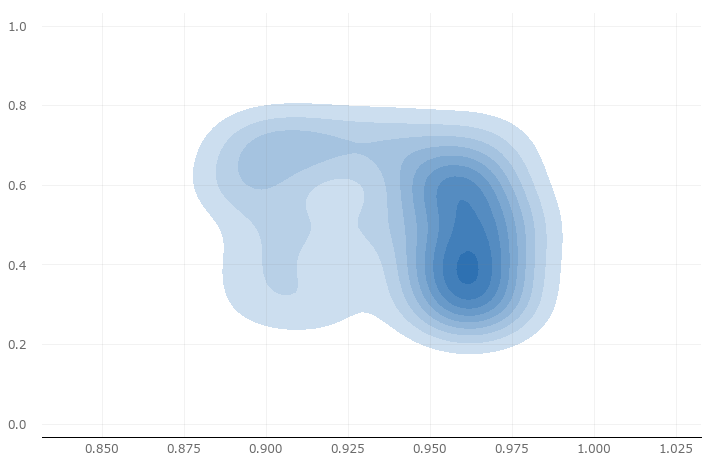

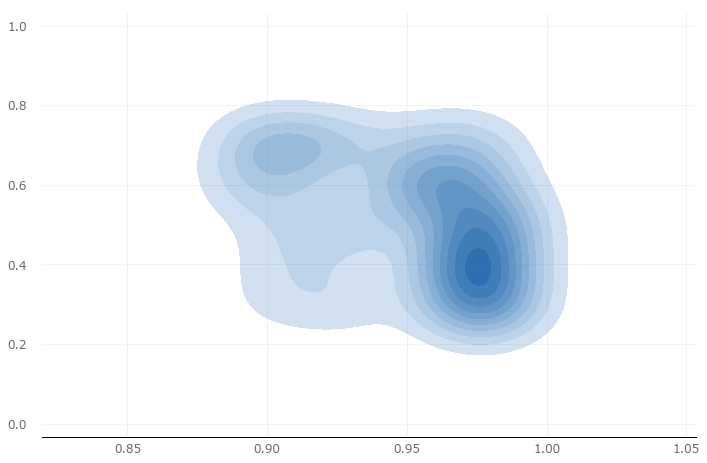

In [45]:
r.plot_kde('val_acc','dropout')
r.plot_kde('acc','dropout')

In [46]:
# get the best paramaters
r.best_params()

array([['Nadam', 'binary_crossentropy', 0.5, 16, 46, 30, 64, 0],
       ['Nadam', 'binary_crossentropy', 0.5, 32, 51, 30, 64, 1],
       ['Adam', 'binary_crossentropy', 0.3, 16, 54, 30, 64, 2],
       ['Adam', 'binary_crossentropy', 0.4, 16, 16, 30, 64, 3],
       ['Nadam', 'binary_crossentropy', 0.4, 16, 22, 30, 64, 4],
       ['Adam', 'binary_crossentropy', 0.5, 32, 41, 30, 64, 5],
       ['Adam', 'binary_crossentropy', 0.7, 32, 24, 30, 64, 6],
       ['Adam', 'binary_crossentropy', 0.5, 16, 4, 30, 64, 7],
       ['Nadam', 'binary_crossentropy', 0.3, 16, 48, 30, 32, 8],
       ['Nadam', 'binary_crossentropy', 0.6, 16, 1, 30, 64, 9]],
      dtype=object)

In [50]:
h.data.sort_values('val_acc',ascending=False)

,round_epochs,val_loss,val_acc,loss,acc,optimizer,losses,first_neuron,batch_size,epochs,dropout,None
46,16,0.073264,0.972005,0.048190,0.981570,Nadam,binary_crossentropy,64,16,30,0.5,46
51,15,0.087422,0.969969,0.047682,0.982658,Nadam,binary_crossentropy,64,32,30,0.5,51
54,11,0.092216,0.968669,0.053887,0.979801,Adam,binary_crossentropy,64,16,30,0.3,54
16,16,0.082590,0.968556,0.047794,0.981434,Adam,binary_crossentropy,64,16,30,0.4,16
22,11,0.083716,0.968386,0.059781,0.977285,Nadam,binary_crossentropy,64,16,30,0.4,22
41,13,0.099858,0.967085,0.052615,0.980368,Adam,binary_crossentropy,64,32,30,0.5,41
24,18,0.096054,0.966859,0.071577,0.976106,Adam,binary_crossentropy,64,32,30,0.7,24
4,11,0.096246,0.966633,0.064050,0.975812,Adam,binary_crossentropy,64,16,30,0.5,4
48,14,0.077868,0.966576,0.059477,0.978260,Nadam,binary_crossentropy,32,16,30,0.3,48
1,9,0.094286,0.965954,0.074021,0.973930,Nadam,binary_crossentropy,64,16,30,0.6,1


#### For Best Model :
1. Best Parameter : Optimizer = Nadam, Loss = binary_crossentropy, Neuron =	64, Batch Size = 16, Epoch = 16, Dropout = 0.5.
2. Trian Accuracy : 0.981570, Test Accuracy : 0.972005
3. Train Loss : 0.048190, Test Loss : 0.073264

## LSTM with 2 layers

In [57]:
def lstm_model_with_2_layer(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    
    model.add(LSTM(units=params['first_neuron'], input_shape=(timesteps, input_dim),return_sequences=True))
    
    model.add(Dropout(rate=params['dropout']))
    
    model.add(LSTM(units=params['second_neuron']))
    
    model.add(Dropout(rate=params['dropout']))
    
    model.add(Dense(n_classes, activation='softmax'))
    
    model.compile(optimizer=params['optimizer'],loss=params['losses'],metrics=['accuracy'])
    
    history = model.fit(x_train, y_train, validation_data=[x_val, y_val],batch_size=params['batch_size'],
                        callbacks=[live(),early_stopper(params['epochs'])],epochs=params['epochs'],
                        verbose=2)

    return history, model

In [55]:
params1 = {
    'optimizer': ['Adam','Nadam'],
    'losses': ['binary_crossentropy'],
    'first_neuron': [64],
    'batch_size': [16,32],
    'epochs': [30],
    'second_neuron': [32,64],
    'dropout': [0.4,0.5,0.7]
}

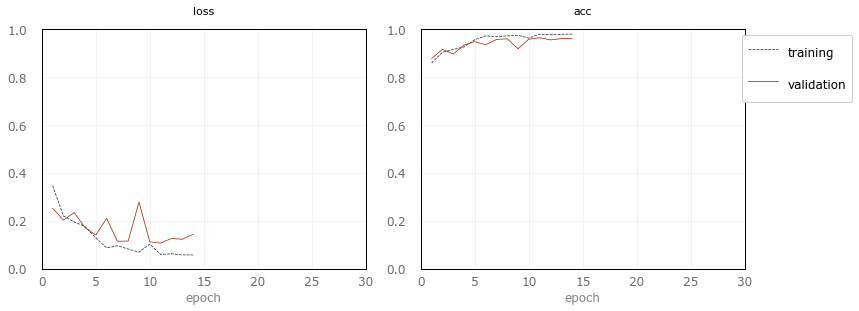


100%|██████████████████████████████████████████████████████████████████████████████| 24/24 [6:11:17<00:00, 1235.98s/it]

In [58]:
h2 = ta.Scan(x=X_train, y=Y_train,x_val=X_test, y_val=Y_test,
          model=lstm_model_with_2_layer,
          params=params1, search_method='random',
          shuffle=True, dataset_name='UCI_HAR_Dataset',
          experiment_no='2', seed=42)

In [59]:
h2.details

experiment_name        UCI_HAR_Dataset_2
random_method           uniform_mersenne
reduction_method                    None
reduction_interval                    50
reduction_window                      20
grid_downsample                        1
reduction_threshold                  0.2
reduction_metric                 val_acc
reduce_loss                        False
complete_time             08/18/19/18:51
x_shape                   (7352, 128, 9)
y_shape                        (7352, 6)
dtype: object

In [60]:
h2.data.head(5)

,round_epochs,val_loss,val_acc,loss,acc,optimizer,losses,first_neuron,batch_size,epochs,second_neuron,dropout
0,4,0.177022,0.923199,0.241181,0.892184,Adam,binary_crossentropy,64,16,30,64,0.4
1,7,0.117321,0.960129,0.112674,0.964477,Nadam,binary_crossentropy,64,32,30,32,0.7
2,11,0.094689,0.965219,0.051301,0.981048,Adam,binary_crossentropy,64,32,30,32,0.4
3,15,0.087462,0.967255,0.051232,0.980980,Adam,binary_crossentropy,64,16,30,32,0.5
4,6,0.117353,0.961995,0.071314,0.976900,Nadam,binary_crossentropy,64,16,30,64,0.7


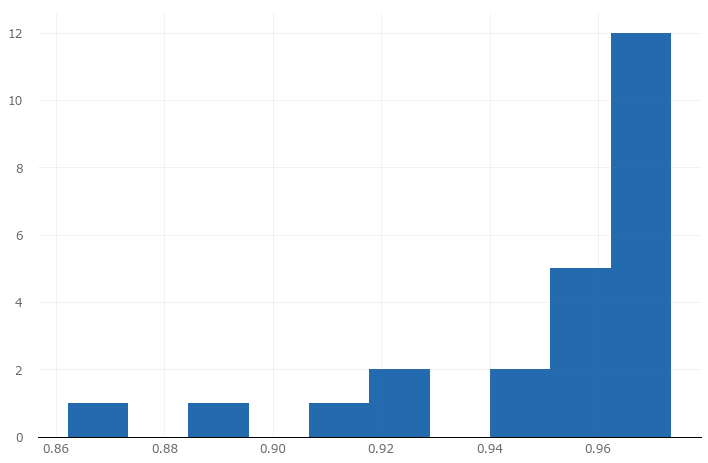

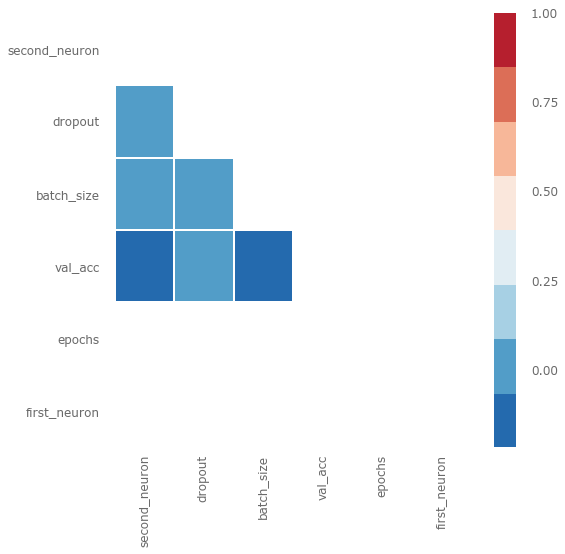

In [61]:
%matplotlib inline
r2 = ta.Reporting(h2)
# a simple histogram 
r2.plot_hist(bins=10)
# heatmap correlation
r2.plot_corr()

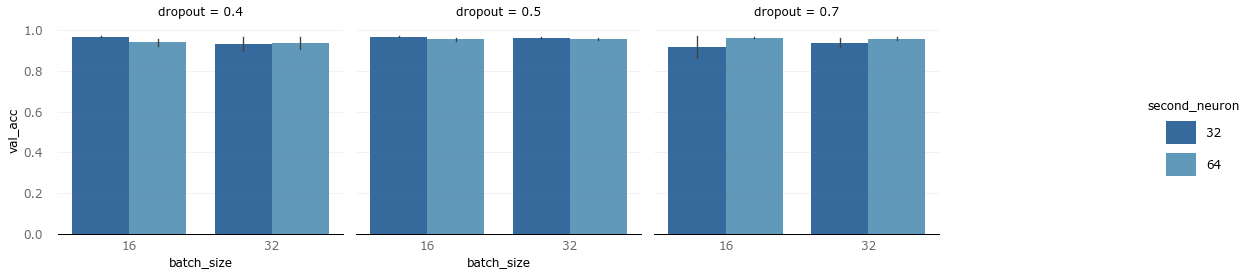

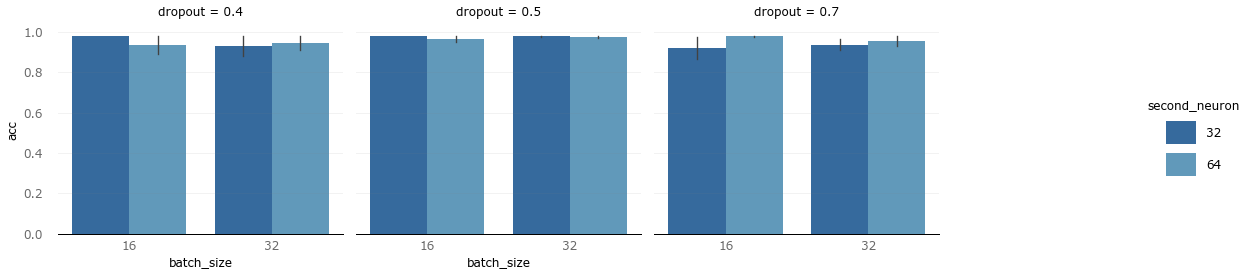

In [62]:
r2.plot_bars('batch_size', 'val_acc', 'second_neuron', 'dropout')
r2.plot_bars('batch_size', 'acc', 'second_neuron', 'dropout')

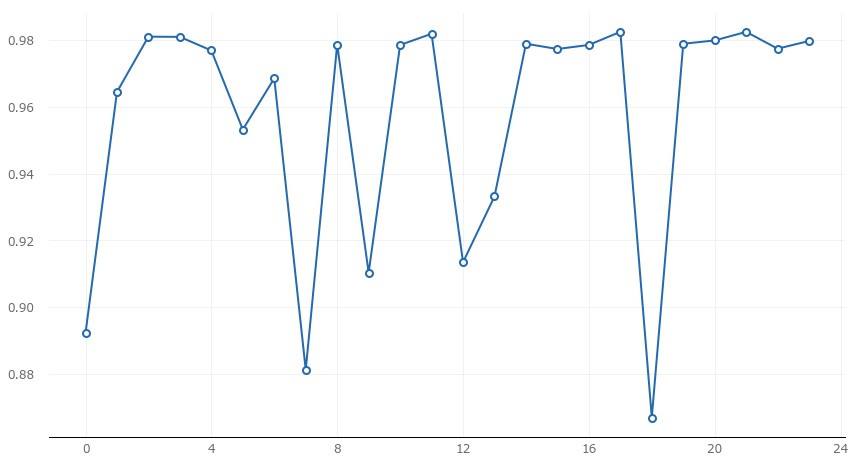

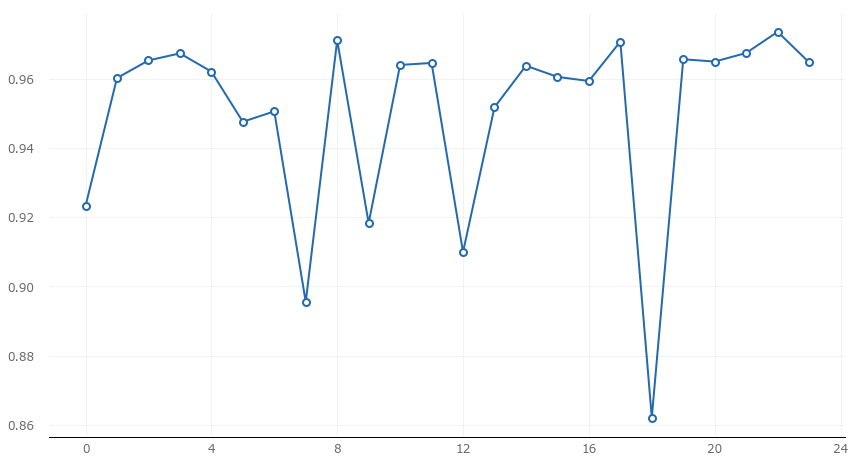

In [63]:
# line plot
r2.plot_line(metric='acc')
r2.plot_line(metric='val_acc')

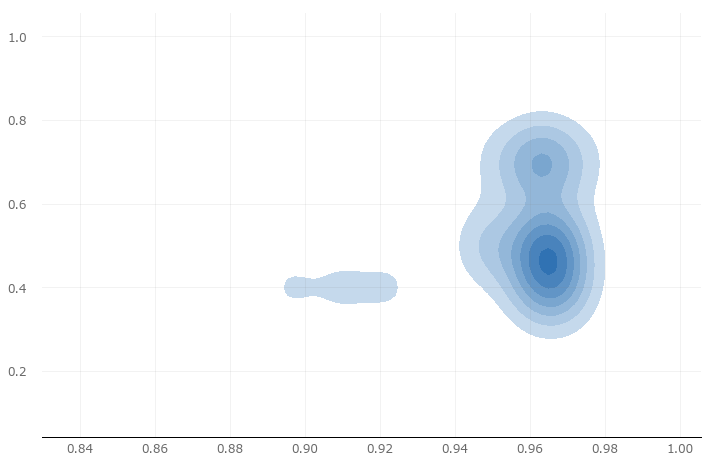

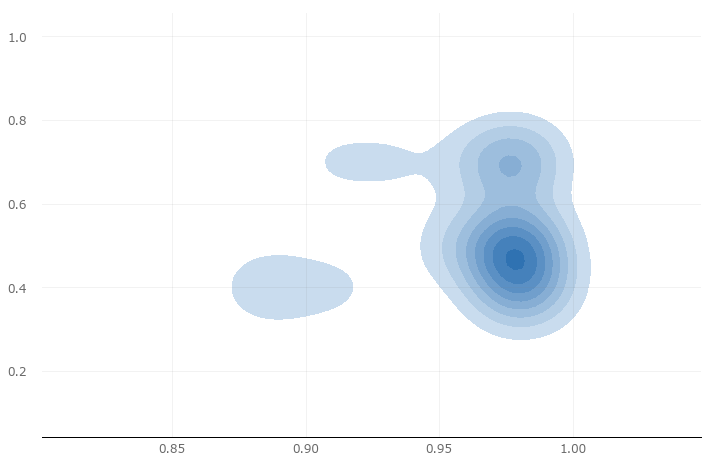

In [64]:
r2.plot_kde('val_acc','dropout')
r2.plot_kde('acc','dropout')

In [65]:
# get the best paramaters
r2.best_params()

array([[32, 'Adam', 'binary_crossentropy', 0.7, 16, 22, 30, 64, 0],
       [32, 'Nadam', 'binary_crossentropy', 0.5, 16, 8, 30, 64, 1],
       [32, 'Nadam', 'binary_crossentropy', 0.4, 16, 17, 30, 64, 2],
       [64, 'Adam', 'binary_crossentropy', 0.4, 32, 21, 30, 64, 3],
       [32, 'Adam', 'binary_crossentropy', 0.5, 16, 3, 30, 64, 4],
       [64, 'Adam', 'binary_crossentropy', 0.7, 32, 19, 30, 64, 5],
       [32, 'Adam', 'binary_crossentropy', 0.4, 32, 2, 30, 64, 6],
       [32, 'Adam', 'binary_crossentropy', 0.4, 16, 20, 30, 64, 7],
       [32, 'Adam', 'binary_crossentropy', 0.5, 32, 23, 30, 64, 8],
       [64, 'Adam', 'binary_crossentropy', 0.7, 16, 11, 30, 64, 9]],
      dtype=object)

In [66]:
h2.data.sort_values('val_acc',ascending=False)

,round_epochs,val_loss,val_acc,loss,acc,optimizer,losses,first_neuron,batch_size,epochs,second_neuron,dropout,None
22,13,0.082830,0.973476,0.070676,0.977444,Adam,binary_crossentropy,64,16,30,32,0.7,22
8,11,0.083986,0.971044,0.057484,0.978668,Nadam,binary_crossentropy,64,16,30,32,0.5,8
17,13,0.087161,0.970648,0.046134,0.982499,Nadam,binary_crossentropy,64,16,30,32,0.4,17
21,14,0.095547,0.967368,0.041268,0.982476,Adam,binary_crossentropy,64,32,30,64,0.4,21
3,15,0.087462,0.967255,0.051232,0.980980,Adam,binary_crossentropy,64,16,30,32,0.5,3
19,18,0.099469,0.965558,0.059289,0.978917,Adam,binary_crossentropy,64,32,30,64,0.7,19
2,11,0.094689,0.965219,0.051301,0.981048,Adam,binary_crossentropy,64,32,30,32,0.4,2
20,9,0.103864,0.964880,0.055018,0.979915,Adam,binary_crossentropy,64,16,30,32,0.4,20
23,14,0.107265,0.964653,0.057808,0.979756,Adam,binary_crossentropy,64,32,30,32,0.5,23
11,7,0.118157,0.964484,0.055836,0.981910,Adam,binary_crossentropy,64,16,30,64,0.7,11


#### For Best Model :
1. Best Parameter : Optimizer = Adam, Loss = binary_crossentropy, 1Neuron = 64, 2Neuron = 32, Batch Size = 16, Epoch = 13, Dropout = 0.7.
2. Trian Accuracy : 0.977444, Test Accuracy : 0.973476
3. Train Loss : 0.070676, Test Loss : 0.082830

In [67]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Optimizer", "Train Acc","Test Auc","Train Loss","Test Loss"]
x.add_row(["LSTM 1Layer","Nadam",0.981,0.972,0.0706,0.0828])
x.add_row(["LSTM 2layer","Adam",0.977,0.973,0.0481,0.0732])

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+-------------+-----------+-----------+----------+------------+-----------+
|    Model    | Optimizer | Train Acc | Test Auc | Train Loss | Test Loss |
+-------------+-----------+-----------+----------+------------+-----------+
| LSTM 1Layer |   Nadam   |   0.981   |  0.972   |   0.0706   |   0.0828  |
| LSTM 2layer |    Adam   |   0.977   |  0.973   |   0.0481   |   0.0732  |
+-------------+-----------+-----------+----------+------------+-----------+
